In [1]:
import numpy as np
import random
import scipy.special as ss
import scipy.optimize as so
import matplotlib.pyplot as plt

A way to estimate the value of an integral is with a sample of numbers generated randomly. 

$$
I_{MC} = \frac{b-a}{N} \sum_{i}^{N} f(x_{i})
$$

Where $f(x)$ is the integral we desire to integrate along the $[a,b]$ interval. And the x_{i} are the random numbers generated uniformly inside $[a,b]$.


In [2]:
def MonteCarlo(fun,interval,N, return_all = False):
    
    M, m = interval[1], interval[0]
    S, I = 0 , []
    
    for i in range(N):
        
        S += fun((M-m)*random.random() + m)
        I.append( S/(i+1) * (M-m) )
        
    if return_all == True: return I
    else: return I[-1]
    
MonteCarlo(lambda x: (x-10)**2 + 5,[0,13],10000)


408.8813750568417

A plausible sophistication of the Monte Carlo method is to take the random numbers not uniformly but from a probability distribution function, this with the idea of weight more properly some regions of the integration that are more importante, for example, where the function varies more. Considering $p(x)$ as pur normalized PDF, the Monte Carlo estimate would be:

$$
I_{MC} = \frac{1}{N} \sum_{i}^{N} \frac{f(x_{i})}{p(x_{i})}
$$

This method is called the importance sampling Montecarlo method, where the $x_{i}$s are taken form $p(x)$.

However, in order to implement the importance sampling Montecarlo integration method is necessary to define correctly the probability distribution function from which the random numbers are taken. Is important to note that for all the values in where $f(x) = 0 $ (the function we want to integrate), the probability distribution function must be also $0$. We can transform the integral as follows:

$$
\int_{a}^{b} f(x) dx = \int_{-\infty}^{\infty} F(x) dx
$$

Where $  F(x) = f(x)$ if $a < x < b$ and $F(x) = 0$ elsewhere. In this sense, our PDF must also nullify in all values outside the integration interval. For example, if we choose as our PDF a gaussian distribution, as it is defined over all the real numbers line, it must nullify also outside the integration interval. For that reason, the idea is at first, define a truncated gaussian distribution where the normalization constant must be recalculated, because is important for the importance Montecarlo method that the probability distribution function be normalized. Then, we consider the following integral:

$$
\DeclareMathOperator\erf{erf}
I(x) = \int \exp{\left[ -\frac{1}{2}\left(   \frac{x-\mu}{\sigma} \right)^{2}  \right]} = - \sqrt{\frac{\pi}{2}} \sigma \erf{ \left( \frac{x-\mu}{\sqrt{2} \sigma}  \right) }
$$

Where $\erf{(x)}$ is the erorr function. Then, a normalized truncated gaussian in the $[a,b]$ interval would be:

$$
G(x ; \mu , \sigma) = \frac{1}{I(b) - I(a)} \exp{\left[ -\frac{1}{2}\left(   \frac{x-\mu}{\sigma} \right)^{2} \right]}
$$

Everything that is considered here, is implemented below. For the evalutation of the error function is used the library scipy.special, and for the generation of a sample distributed according to the truncated gaussian is implemented the Metropolis-Hasting algorithm.

In [3]:
class Truncated_Gaussian:
    
    def __init__(self,mu,sg,interval):
        
        self.mu = mu
        self.sg = sg
        self.a = interval[0]
        self.b = interval[1]   
        
    def ind_integral(self,x):
        
        return -np.sqrt(np.pi/2) * self.sg * ss.erf((self.mu - x)/np.sqrt(2)/self.sg)
     
    def Norm_calc(self):
        
        return 1 / (self.ind_integral(self.b) - self.ind_integral(self.a))
    
    def pdf(self,x):
        
        if self.a < x < self.b:
            val = self.Norm_calc() * np.e**(-0.5*((x/self.sg - self.mu/self.sg)**2 ))
        else:
            val = 0
        return val
    
    def Metropolis_Generator(self,N):
        
        x0 = random.random()*(self.b - self.a) + self.a 
        Accepted_values = []

        while len(Accepted_values) < N:
    
            x_candidate = random.random()*(self.b - self.a) + self.a 
            prob = min(1, self.pdf(x_candidate) / self.pdf(x0))
    
            if random.random() < prob : Accepted_values.append(x_candidate)
            if prob == 1: x0 = x_candidate
                
        return Accepted_values
       

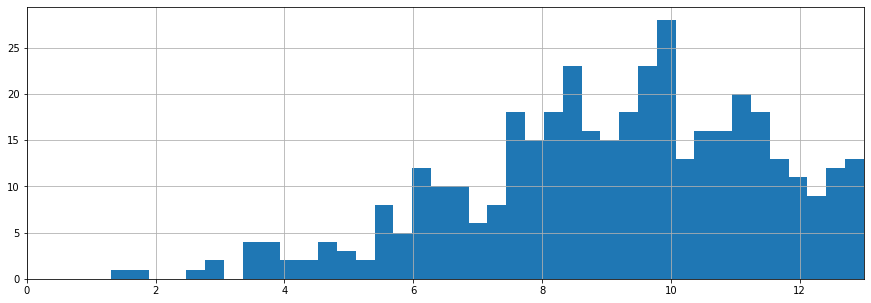

In [4]:
# Histogram for a truncated gaussian

mu, sg, interval =  10, 3, [0,13]
pdf = Truncated_Gaussian(mu, sg, interval)

fig = plt.figure(figsize = [15,5])
plt.hist(pdf.Metropolis_Generator(400), bins = 40)
plt.xlim(interval)
plt.grid()
plt.show()


In [5]:
def Importance_MonteCarlo(fun,mu,sg,interval,N, return_all = False):
    
    pdf = Truncated_Gaussian(mu, sg, interval)
    Sample = pdf.Metropolis_Generator(N)
    S, I = 0, []
    
    for i,x in enumerate(Sample):
        
        S += fun(x)/pdf.pdf(x)
        I.append( S/(i+1))
    
    if return_all == True: return I
    else: return I[-1]

In [6]:
mu, sg, interval, N = 10, 3.5 , [0,13], 10000
Importance_MonteCarlo(lambda x: (x-10)**2 + 5, mu, sg, interval, N)

374.01545875638124

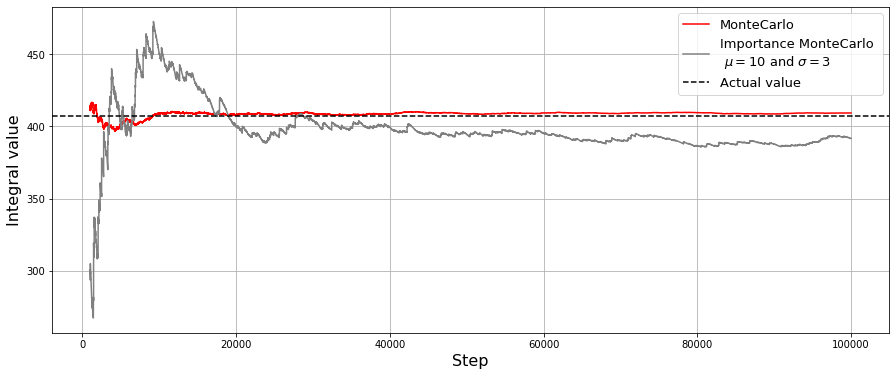

In [7]:
mu, sg, interval, N = 10, 3 , [0,13], 100000
f = lambda x: (x-10)**2 + 5

MC = MonteCarlo(f,interval,N, return_all = True)
IMC = Importance_MonteCarlo(f, mu, sg, interval, N, return_all = True)
fig = plt.figure( figsize = [15,6])
steps = range(N)

plt.plot(steps[int(N/100):], MC[int(N/100):], color = "red", label = "MonteCarlo")
plt.plot(steps[int(N/100):],IMC[int(N/100):], color = "gray", 
         label = "Importance MonteCarlo \n $\mu = {}$ and $\sigma = {}$".format(mu,sg))
plt.axhline(1222/3, ls = "--",  color = "black", label = "Actual value")

plt.xlabel("Step", fontsize = 16)
plt.ylabel("Integral value", fontsize = 16)
plt.legend(loc = "best",fontsize = 13)
plt.grid()
plt.show()

The convergence of the standard MonteCarlo method is not quite fast but for large N it comes to the expected value whereas the importance sampling method usually converges slowly for $\mu = 10$ and small $\sigma$. This is a expected outcome given that if one takes more samples in the neighbourhood of $x=10$ it will skew the value of the integral because the values near $x = 0$ are larger. On the other hand, if one takes $\sigma$ larger, the truncated gaussian will tend to a uniform distribution and the outcome would be similar of the standard MonteCarlo method. An idea to find the optimal values for the parameters of the truncated gaussian distribution is to define an error or a deviation of the actual value in order to determine for which values the method converges faster. Even if this could sound as a cheat because is necessary to know the value of the integral to define the error, there are other ways to define a sort of variance of the method but given that we know the value of the integral, we will use it and hence define the error as follows:

$$
\epsilon =  \frac{1}{N}\sum_{i=0}^{N} (  I_{i}^{(MC)} - I)^{2}
$$

Where the sum is taken for all the calculated values to punished the values of slow convergence. 

Well now, beliving that if the shape of the probability distribution is likely to the shape of the function we desire to integrate, it could be reasonable to fit the function with a not-normalized gaussian, and use the parameters as a start-point for the minimization algorithm.



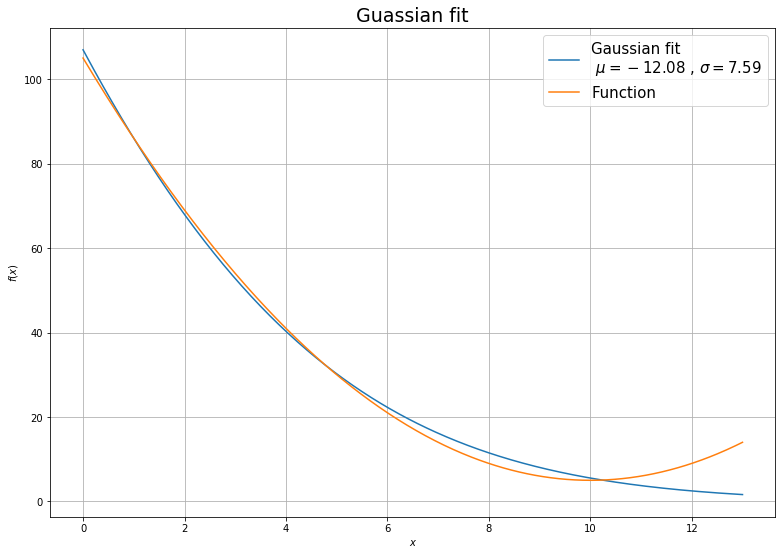

In [8]:
def Fit_with_truncated_gaussian(fun,interval):
    
    M, m =  interval[1] , interval[0]
    
    x = np.linspace(m,M,500)
    y = fun(x)
    gauss = lambda x, A, mu, sg : A* np.e**(  -0.5*((x-mu)/sg)**2   )
   
    ( A_opt , mu_opt , sg_opt) , _  = so.curve_fit(gauss,x,y)
       
    fig = plt.figure(figsize = [13,9])    
        
    plt.plot(x, gauss(x,A_opt,mu_opt,sg_opt), 
             label = "Gaussian fit\n $\mu = {}$ , $\sigma = {}$".format(round(mu_opt,2), round(sg_opt,2)))
    plt.plot(x,fun(x), label = "Function")
    
    plt.legend(loc = "best", fontsize = 15)
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.title("Guassian fit", fontsize = 19)
    plt.grid()
    plt.show()
    

    return mu_opt, sg_opt

mu_opt , sg_opt = Fit_with_truncated_gaussian(f,interval)

In [9]:
def MonteCarlo_error(fun, interval, N, actual_value, method = "Standard", mu  = None, sg = None):
        
    if method == "Standard":    
        err = sum([( integral - actual_value)**2 for integral in MonteCarlo(fun,interval,N,return_all = True) ])/N 
    
    elif method == "Importance_sampling":
        err = sum([( integral - actual_value)**2 for integral in 
                   Importance_MonteCarlo(fun,mu,sg,interval,N,return_all = True) ])/N 
        
    return err

In [10]:
# Estimation of errors multiple times becuase the randomness of the experiment

f, interval, N = lambda x: (x-10)**2 + 5, [0,13], 10000
epochs = 10
e_std , e_opt , e_imp = 0,0,0

for e in range(epochs):
    
    e_std += MonteCarlo_error(f,interval,N, 1222/3)
    e_opt += MonteCarlo_error(f,interval,N, 1222/3, method = "Importance_sampling", mu = mu_opt, sg = sg_opt)
    e_imp += MonteCarlo_error(f,interval,N, 1222/3, method = "Importance_sampling", mu = 10, sg = 3.5)
    
e_std , e_opt , e_imp = e_std/epochs , e_opt/epochs , e_imp/epochs

In [11]:
print ("Mean error for the standard method: ",round(e_std,2))
print ("Mean error for the importance method: ",round(e_imp,2))
print ("Mean error for the fitted importance method: ",round(e_opt,2))

Mean error for the standard method:  133.51
Mean error for the importance method:  1842.51
Mean error for the fitted importance method:  31.05


In [12]:
Importance_MonteCarlo(f,mu_opt,sg_opt,interval,N)

407.0703636953161

The importance sampling method converges to the actual value more faster than the standard method given a situable probability distribution function, if not, it will skew the outcome. 